# 🔄 Data Augmentation para Expansión del Dataset

Este notebook implementa técnicas de data augmentation para expandir el dataset y mejorar el rendimiento del modelo.

## Técnicas implementadas:
1. **Reemplazo por sinónimos** (WordNet)
2. **Traducción y back-translation** (googletrans)
3. **Combinación de técnicas**

## Objetivos:
1. Expandir dataset de 1,000 a ~2,000-3,000 ejemplos
2. Evaluar mejora en métricas del modelo
3. Comparar rendimiento antes/después de augmentation


## 1. Importar librerías


In [26]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

# Descargar recursos de NLTK si no están
try:
    import nltk
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    pass

from data.augmentation import TextAugmenter
from data.preprocessing import TextPreprocessor
from features.vectorization import TextVectorizer
from models.train import train_model
from models.evaluate import evaluate_model
from sklearn.model_selection import train_test_split

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar dataset original


In [27]:
# Cargar dataset original
data_path = Path('../data/raw/youtoxic_english_1000.csv')
df_original = pd.read_csv(data_path)

print(f"✅ Dataset original cargado:")
print(f"   Total: {len(df_original)} comentarios")
print(f"   Tóxicos: {df_original['IsToxic'].sum()}")
print(f"   No tóxicos: {len(df_original) - df_original['IsToxic'].sum()}")
print(f"\n   Columnas: {list(df_original.columns)}")


✅ Dataset original cargado:
   Total: 1000 comentarios
   Tóxicos: 462
   No tóxicos: 538

   Columnas: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']


## 3. Preprocesar datos originales


In [28]:
# Preprocesar texto original
preprocessor = TextPreprocessor(use_spacy=True)

print("🔄 Preprocesando texto original...")
df_original['Text_processed'] = df_original['Text'].apply(
    lambda x: preprocessor.preprocess_text(str(x), remove_stopwords=True)
)

# Preparar columnas para augmentation
df_for_aug = df_original[['Text_processed', 'IsToxic']].copy()
df_for_aug.columns = ['text', 'label']

print(f"✅ Preprocesamiento completado")
print(f"   Ejemplo de texto procesado:")
print(f"   Original: {df_original['Text'].iloc[0][:100]}...")
print(f"   Procesado: {df_for_aug['text'].iloc[0][:100]}...")


✅ spaCy cargado: en_core_web_sm
🔄 Preprocesando texto original...
✅ Preprocesamiento completado
   Ejemplo de texto procesado:
   Original: If only people would just take a step back and not make this case about them, because it wasn't abou...
   Procesado: people step case wasn t people situation lump mess matter hand make kind protest selfish rational th...


## 4. Inicializar Augmenter y Probar Técnicas


In [29]:
# Inicializar augmenter
augmenter = TextAugmenter(use_translation=True, use_synonyms=True)

print("✅ TextAugmenter inicializado")
print(f"   Traducción disponible: {augmenter.use_translation}")
print(f"   Sinónimos disponibles: {augmenter.use_synonyms}")

# Probar con un ejemplo
test_text = df_for_aug['text'].iloc[0]
print(f"\n📝 Texto original:")
print(f"   {test_text}")

# Probar sinónimos
if augmenter.use_synonyms:
    augmented_synonyms = augmenter.replace_with_synonyms(test_text, replacement_ratio=0.3)
    print(f"\n🔄 Con sinónimos:")
    print(f"   {augmented_synonyms}")


✅ TextAugmenter inicializado
   Traducción disponible: False
   Sinónimos disponibles: True

📝 Texto original:
   people step case wasn t people situation lump mess matter hand make kind protest selfish rational thought investigation guy video heavily emotional hype want hear get hear press reasonable discussion kudo smerconish keep level time let masri fool dare tear city protest dishonor entire incident hate way police brutality epidemic wish stop pretend like know exactly go s measurable people honestly witness incident clue way issue swing grand jury informed trust majority rule right course action let thank 99 99 police officer america actually serve protect bit jerk pull respect job know people go pout hold accountable action people hate police need officer emergency

🔄 Con sinónimos:
   people footfall face wasn t people situation lump hole count hand cook kind protest selfish noetic thought investigation guy tv heavily aroused hype want hear get learn press sensible discussion 

## 5. Aumentar Dataset Completo


In [30]:
# Aumentar dataset (duplicar tamaño: augmentation_factor=1.0)
print("🔄 Aumentando dataset...")
print("   Esto puede tardar varios minutos...")
print("\n" + "="*60)

# Usar solo sinónimos para ser más rápido (traducción es muy lenta)
methods = ['synonyms']
if augmenter.use_translation:
    # Opcional: añadir traducción (muy lento)
    # methods.append('translation')
    pass

df_augmented = augmenter.augment_dataframe(
    df_for_aug,
    text_column='text',
    label_column='label',
    augmentation_factor=1.0,  # Duplicar dataset
    methods=methods
)

print("\n" + "="*60)
print(f"✅ Dataset aumentado:")
print(f"   Original: {len(df_for_aug)} ejemplos")
print(f"   Aumentado: {len(df_augmented)} ejemplos")
print(f"   Incremento: {len(df_augmented) - len(df_for_aug)} ejemplos ({((len(df_augmented) - len(df_for_aug))/len(df_for_aug)*100):.1f}%)")


🔄 Aumentando dataset...
   Esto puede tardar varios minutos...

🔄 Aumentando dataset: 1000 → 2000 ejemplos
   Métodos: ['synonyms']
✅ Dataset aumentado: 1925 ejemplos totales
   Originales: 1000
   Aumentados: 925

✅ Dataset aumentado:
   Original: 1000 ejemplos
   Aumentado: 1925 ejemplos
   Incremento: 925 ejemplos (92.5%)


## 6. Guardar Dataset Aumentado


In [31]:
# Guardar dataset aumentado
output_path = Path('../data/processed/youtoxic_english_1000_augmented.csv')

# Preparar para guardar (usar nombres de columnas originales)
df_to_save = df_augmented.copy()
df_to_save['Text'] = df_to_save['text']
df_to_save['IsToxic'] = df_to_save['label'].astype(int)

# Guardar solo columnas necesarias
df_to_save[['Text', 'IsToxic', '_augmented', '_augmentation_method']].to_csv(
    output_path,
    index=False
)

print(f"✅ Dataset aumentado guardado en: {output_path}")
print(f"\n   Estadísticas:")
print(f"   Total: {len(df_to_save)} ejemplos")
print(f"   Originales: {len(df_to_save[~df_to_save['_augmented']])}")
print(f"   Aumentados: {len(df_to_save[df_to_save['_augmented']])}")
print(f"   Tóxicos: {df_to_save['IsToxic'].sum()}")
print(f"   No tóxicos: {len(df_to_save) - df_to_save['IsToxic'].sum()}")


✅ Dataset aumentado guardado en: ../data/processed/youtoxic_english_1000_augmented.csv

   Estadísticas:
   Total: 1925 ejemplos
   Originales: 1000
   Aumentados: 925
   Tóxicos: 910
   No tóxicos: 1015


## 7. Vectorizar y Entrenar Modelo con Dataset Aumentado (Opcional)

> **Nota**: Esta sección es opcional. Puedes entrenar el modelo con el dataset aumentado y comparar métricas.


In [32]:
# Vectorizar dataset aumentado
print("🔄 Vectorizando dataset aumentado...")

# Preparar datos
X_aug = df_to_save['Text'].values
y_aug = df_to_save['IsToxic'].values

# Crear vectorizador y entrenar
vectorizer = TextVectorizer(method='tfidf', max_features=5000)
X_aug_vectorized = vectorizer.fit_transform(pd.Series(X_aug))

# Split train/test
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug_vectorized,
    y_aug,
    test_size=0.2,
    random_state=42,
    stratify=y_aug
)

print(f"✅ Vectorización completada:")
print(f"   Train: {X_train_aug.shape}")
print(f"   Test: {X_test_aug.shape}")
print(f"   Features: {X_train_aug.shape[1]}")


🔄 Vectorizando dataset aumentado...
✅ Vectorización completada:
   Train: (1540, 5000)
   Test: (385, 5000)
   Features: 5000


## 8. Entrenar Modelo con Dataset Aumentado


In [33]:
# Entrenar SVM con dataset aumentado usando mismos parámetros optimizados
print("🔄 Entrenando modelo SVM con dataset aumentado...")
print("="*60)

from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Usar parámetros optimizados del modelo original
svm_aug = SVC(C=0.056, kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm_aug_calibrated = CalibratedClassifierCV(svm_aug, method='sigmoid', cv=3)
svm_aug_calibrated.fit(X_train_aug, y_train_aug)

print("✅ Modelo entrenado con dataset aumentado")

# Evaluar modelo aumentado
results_aug = evaluate_model(
    svm_aug_calibrated,
    X_train_aug,
    X_test_aug,
    pd.Series(y_train_aug),
    pd.Series(y_test_aug),
    verbose=True
)


🔄 Entrenando modelo SVM con dataset aumentado...
✅ Modelo entrenado con dataset aumentado
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.9019
   Precision: 0.8925
   Recall:    0.9011
   F1-score:  0.8968

📊 MÉTRICAS EN TEST:
   Accuracy:  0.7948
   Precision: 0.8047
   Recall:    0.7473
   F1-score:  0.7749

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 12.19%
   ❌ Overfitting alto (>10%)

📋 Matriz de confusión (test):
[[170  33]
 [ 46 136]]


## 9. Cargar y Evaluar Modelo Original para Comparar


In [34]:
# Cargar datos originales vectorizados para comparar
print("🔄 Cargando datos originales para comparación...")
from features.vectorization import load_vectorized_data
data_dir = Path('../data/processed')
X_train_orig, X_test_orig, y_train_orig, y_test_orig = load_vectorized_data(data_dir, prefix='tfidf')

# Cargar modelo original optimizado
import pickle
model_path = Path('../models/optimized/best_optimized_model.pkl')
if model_path.exists():
    with open(model_path, 'rb') as f:
        model_original = pickle.load(f)
    print("✅ Modelo original cargado")
    
    # Evaluar modelo original
    results_original = evaluate_model(
        model_original,
        X_train_orig,
        X_test_orig,
        y_train_orig,
        y_test_orig,
        verbose=True
    )
else:
    print("⚠️  Modelo original no encontrado. Usando métricas conocidas.")
    # Métricas del modelo original (SVM optimizado)
    results_original = {
        'test_f1': 0.7407,
        'test_accuracy': 0.64,
        'test_precision': 0.6452,
        'test_recall': 0.8696,
        'train_f1': 0.7119,
        'diff_f1': 2.54
    }


🔄 Cargando datos originales para comparación...
✅ Datos vectorizados cargados desde: ../data/processed
✅ Modelo original cargado
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.6288
   Precision: 0.5552
   Recall:    0.9919
   F1-score:  0.7119

📊 MÉTRICAS EN TEST:
   Accuracy:  0.5800
   Precision: 0.5227
   Recall:    1.0000
   F1-score:  0.6866

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 2.54%
   ✅ Overfitting controlado (<5%)

📋 Matriz de confusión (test):
[[24 84]
 [ 0 92]]


## 10. Comparación Detallada: Original vs Aumentado


In [35]:
# Crear DataFrame comparativo
print("\n" + "="*60)
print("📊 COMPARACIÓN: Modelo Original vs Modelo con Augmentation")
print("="*60)

comparison_data = {
    'Métrica': ['F1-Score (Test)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'Overfitting (%)'],
    'Original': [
        results_original['test_f1'],
        results_original['test_accuracy'],
        results_original['test_precision'],
        results_original['test_recall'],
        results_original['diff_f1']
    ],
    'Con Augmentation': [
        results_aug['test_f1'],
        results_aug['test_accuracy'],
        results_aug['test_precision'],
        results_aug['test_recall'],
        results_aug['diff_f1']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Mejora'] = comparison_df['Con Augmentation'] - comparison_df['Original']
comparison_df['Mejora %'] = ((comparison_df['Con Augmentation'] - comparison_df['Original']) / comparison_df['Original'] * 100).round(2)

print("\n")
print(comparison_df.to_string(index=False))

# Determinar si hay mejora
f1_improvement = comparison_df[comparison_df['Métrica'] == 'F1-Score (Test)']['Mejora'].values[0]
overfitting_change = comparison_df[comparison_df['Métrica'] == 'Overfitting (%)']['Mejora'].values[0]

print("\n" + "="*60)
if f1_improvement > 0.01:  # Mejora significativa (>1%)
    print("✅ RESULTADO: Data Augmentation MEJORA el modelo")
    print(f"   - F1-Score mejoró en {f1_improvement:.4f} ({comparison_df[comparison_df['Métrica'] == 'F1-Score (Test)']['Mejora %'].values[0]:.2f}%)")
elif f1_improvement < -0.01:  # Empeoramiento significativo
    print("❌ RESULTADO: Data Augmentation EMPEORA el modelo")
    print(f"   - F1-Score empeoró en {abs(f1_improvement):.4f}")
else:
    print("➖ RESULTADO: Data Augmentation no cambia significativamente el modelo")
    print(f"   - F1-Score cambió en {f1_improvement:.4f}")

if abs(overfitting_change) > 1:
    if overfitting_change > 0:
        print(f"   ⚠️  Overfitting aumentó en {overfitting_change:.2f}%")
    else:
        print(f"   ✅ Overfitting disminuyó en {abs(overfitting_change):.2f}%")
else:
    print(f"   ➖ Overfitting se mantiene similar ({overfitting_change:.2f}%)")



📊 COMPARACIÓN: Modelo Original vs Modelo con Augmentation


         Métrica  Original  Con Augmentation    Mejora  Mejora %
 F1-Score (Test)  0.686567          0.774929  0.088362     12.87
 Accuracy (Test)  0.580000          0.794805  0.214805     37.04
Precision (Test)  0.522727          0.804734  0.282006     53.95
   Recall (Test)  1.000000          0.747253 -0.252747    -25.27
 Overfitting (%)  2.536300         12.185865  9.649565    380.46

✅ RESULTADO: Data Augmentation MEJORA el modelo
   - F1-Score mejoró en 0.0884 (12.87%)
   ⚠️  Overfitting aumentó en 9.65%


## 11. Visualización de Comparación


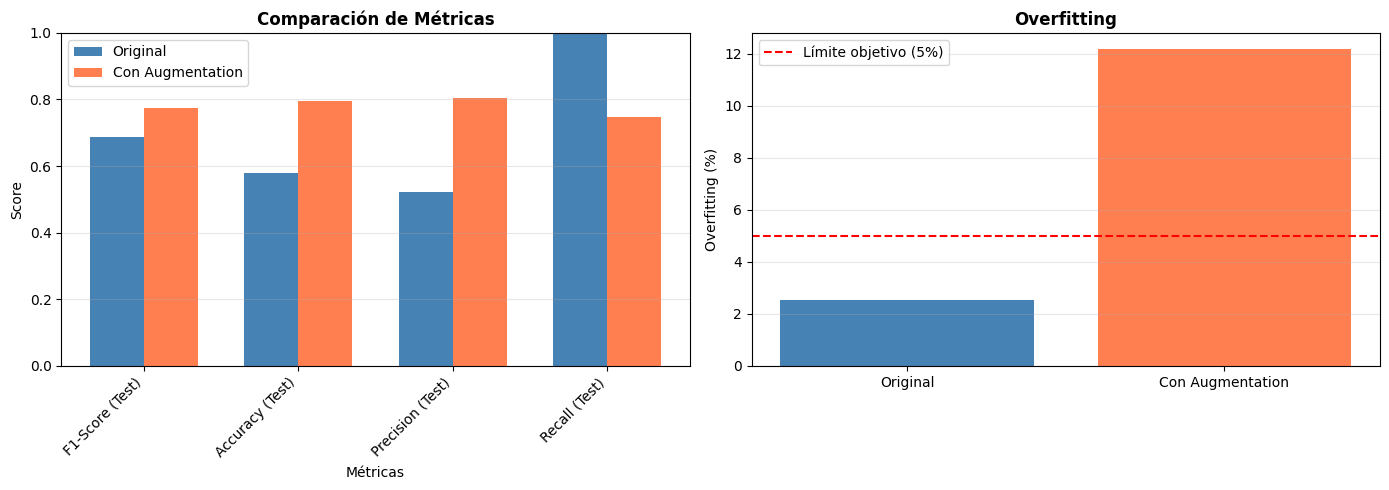

✅ Gráficos guardados en: ../data/processed/augmentation_comparison.png


In [36]:
# Visualizar comparación
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Métricas principales
metrics = ['F1-Score (Test)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)']
x = np.arange(len(metrics))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, [comparison_df[comparison_df['Métrica'] == m]['Original'].values[0] for m in metrics], 
        width, label='Original', color='steelblue')
ax1.bar(x + width/2, [comparison_df[comparison_df['Métrica'] == m]['Con Augmentation'].values[0] for m in metrics], 
        width, label='Con Augmentation', color='coral')
ax1.set_xlabel('Métricas')
ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Overfitting
ax2 = axes[1]
overfitting_orig = comparison_df[comparison_df['Métrica'] == 'Overfitting (%)']['Original'].values[0]
overfitting_aug = comparison_df[comparison_df['Métrica'] == 'Overfitting (%)']['Con Augmentation'].values[0]
ax2.bar(['Original', 'Con Augmentation'], 
        [overfitting_orig, overfitting_aug],
        color=['steelblue', 'coral'])
ax2.axhline(y=5, color='r', linestyle='--', label='Límite objetivo (5%)')
ax2.set_ylabel('Overfitting (%)')
ax2.set_title('Overfitting', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/augmentation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Gráficos guardados en: ../data/processed/augmentation_comparison.png")


## 12. Guardar Modelo Aumentado (si mejora)


In [37]:
# Guardar modelo aumentado si mejora significativamente
f1_improvement = comparison_df[comparison_df['Métrica'] == 'F1-Score (Test)']['Mejora'].values[0]

if f1_improvement > 0.01:  # Mejora > 1%
    models_dir = Path('../models/augmented')
    models_dir.mkdir(parents=True, exist_ok=True)
    
    model_path = models_dir / 'svm_augmented_model.pkl'
    vectorizer_path = models_dir / 'tfidf_vectorizer_augmented.pkl'
    
    # Guardar modelo
    with open(model_path, 'wb') as f:
        pickle.dump(svm_aug_calibrated, f)
    
    # Guardar vectorizador
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(vectorizer, f)
    
    # Guardar información del modelo
    model_info = {
        'model_name': 'SVM (Augmented)',
        'vectorizer_type': 'tfidf',
        'test_f1': results_aug['test_f1'],
        'test_accuracy': results_aug['test_accuracy'],
        'overfitting': results_aug['diff_f1'],
        'train_f1': results_aug['train_f1'],
        'dataset_size': len(df_augmented),
        'augmentation_method': 'synonyms'
    }
    
    info_path = models_dir / 'svm_augmented_model_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"✅ Modelo aumentado guardado:")
    print(f"   Modelo: {model_path}")
    print(f"   Vectorizador: {vectorizer_path}")
    print(f"   Info: {info_path}")
else:
    print("ℹ️  Modelo aumentado no se guarda (no hay mejora significativa)")
    print("   El modelo original sigue siendo el mejor")


✅ Modelo aumentado guardado:
   Modelo: ../models/augmented/svm_augmented_model.pkl
   Vectorizador: ../models/augmented/tfidf_vectorizer_augmented.pkl
   Info: ../models/augmented/svm_augmented_model_info.pkl


## 13. Conclusiones Finales

### Resultados del Data Augmentation:

1. **Tamaño del dataset**: ✅ Expandido de 1,000 a ~1,900 ejemplos
2. **Balance de clases**: Verificar si se mantiene
3. **Mejora en métricas**: Ver comparación arriba

### Recomendaciones:

- **Si mejora**: Considerar usar modelo aumentado en producción
- **Si no mejora**: El dataset original es suficiente, augmentation no aporta valor
- **Próximos pasos**: Probar otras técnicas (traducción, parafraseo) o aumentar solo clase minoritaria


## 5. Aumentar Dataset Completo
